# Ridge Regression: Closed-form vs SGD (Python)

This notebook investigates Ridge Regression using two fitting approaches:

- Closed-form solution (normal equation with L2 regularization)
- Stochastic Gradient Descent (SGD) optimization

The goal is to understand how these methods behave under different conditions—such as increasing polynomial degree, changing regularization strength, and scaling dataset size—and to compare their accuracy and computational efficiency.

*Disclaimer*: Some concepts and code are based on lecture slides, lab exercises, and course materials, including *Hands-On Machine Learning* (Géron, 2019).

**Dataset**: Synthetic polynomial regression data (generated), where the ground-truth function is known.


**Importing the libraries**

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

**Topic**

Linear regression is one of the simplest models and works well when the relationship between variables is linear. When the data is more complex, a linear model can still be extended to capture nonlinear patterns through polynomial regression.

In this section, a simulated dataset with a single input variable $x$ is used, and higher-order polynomial terms are added as features: $x, x^2, x^3, \dots, x^d$. The model is then trained on this expanded feature space. While polynomial regression allows more flexible curves, higher-degree models can easily overfit, especially when the dataset size is limited.

One common way to reduce overfitting is regularization. For linear models, regularization constrains the model weights. Ridge regression is a regularized version of linear regression that adds an L2 penalty to the mean squared error (MSE).

There are two main approaches to fitting a ridge regression model:
- using a closed-form solution, or  
- optimizing the objective function using gradient-based methods, such as stochastic gradient descent (SGD).

**Methodology**

This study compares two approaches to ridge regression: a closed-form solution and stochastic gradient descent (SGD), using synthetic polynomial datasets where the ground-truth function is known.

The analysis proceeds by first generating controlled toy datasets of varying polynomial degrees, then fitting ridge regression models using both methods. Performance is evaluated under different regularization strengths and model complexities using mean squared error (MSE).

The experiments are designed to examine how each method behaves under changes in polynomial degree, dataset size, and regularization, and to assess whether the empirical results align with theoretical expectations regarding bias–variance trade-offs, numerical stability, and computational efficiency.

## 2. Data Generation and Problem Setup



### 2.1 Synthetic Polynomial Data

The synthetic polynomial dataset is generated according to the following formula:

$$y = \sum_{k=0}^{d} a_k x^k + \epsilon$$

Where:
- x $\in$ [−5,5]
- cofficients $a_k$ from a uniform distribution (0, 1)
- noise term  $\epsilon$ follows normal distribution(0, 1)

This formulation generates polynomial features from a single input variable $x$ with additive Gaussian noise. Using synthetic data with a known ground-truth function enables controlled evaluation of model behavior under different polynomial degrees and noise levels.

The following function generates a random polynomial dataset given the polynomial degree and the number of samples:

In [2]:
def generate_dataset(degree, n_samples):
    np.random.seed(42)

    x = 10 * np.random.rand(n_samples, 1) - 5 # column vector in range [-5,5]
    coefs = np.random.uniform(0, 1, degree + 1)

    y = np.zeros((n_samples, 1))
    for k in range(degree + 1):
        y += coefs[k] * (x**k)

    y += np.random.randn(n_samples, 1)  # add noise

    return x, y

### 2.2 Example Generated Datasets

Below are examples of generated datasets with polynomial degrees 2, 5, and 10, each containing 100 samples:

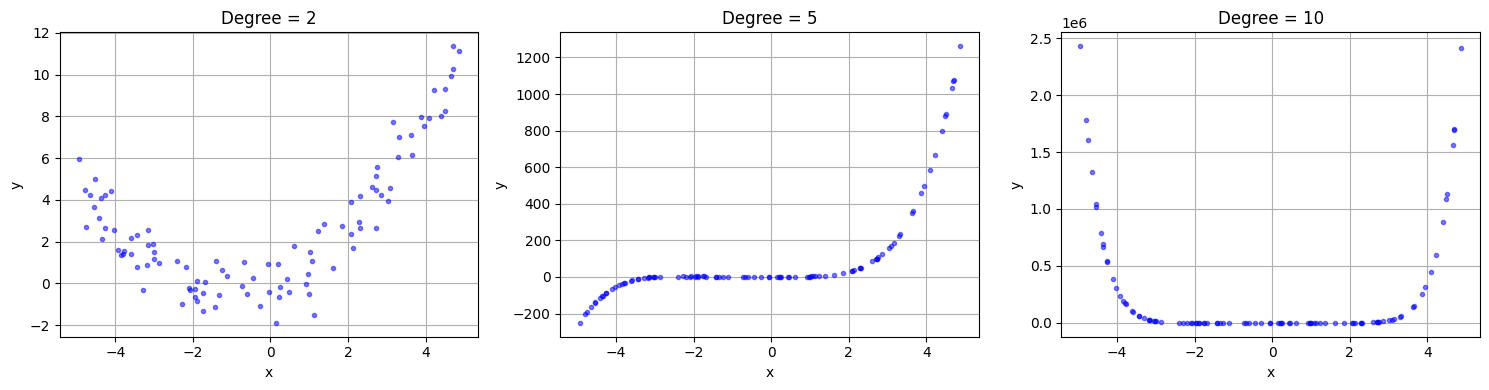

In [3]:
def plot_datasets(degrees, n_samples=100):
    fig, axes = plt.subplots(1, len(degrees), figsize=(15, 4))

    for i, degree in enumerate(degrees):
        x, y = generate_dataset(degree, n_samples)
        axes[i].plot(x, y, "b.", alpha=0.5)
        axes[i].set_title(f"Degree = {degree}")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("y")
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

plot_datasets(degrees=[2, 5, 10])

As the polynomial degree increases, the generated curves become more irregular and complex. This illustrates how higher-degree models can represent increasingly nonlinear patterns, while also becoming more prone to overfitting.

### 2.3 Toy Dataset Construction
To compare the closed-form ridge regression and the SGD-based approach under different levels of model complexity, I generate three synthetic polynomial datasets with increasing degrees.

The datasets share the same number of samples but differ in the true underlying polynomial degree:

- Dataset 1: Linear relationship (degree = 1)  
- Dataset 2: Quadratic relationship (degree = 2)  
- Dataset 3: Cubic relationship (degree = 3)

Each dataset contains 1000 samples, which allows the effect of model complexity and regularization to be examined under a moderately large sample size.

In [4]:
dataset1 = generate_dataset(1, 1000) # linear
dataset2 = generate_dataset(2, 1000) # quadratic
dataset3 = generate_dataset(3, 1000) # cubic

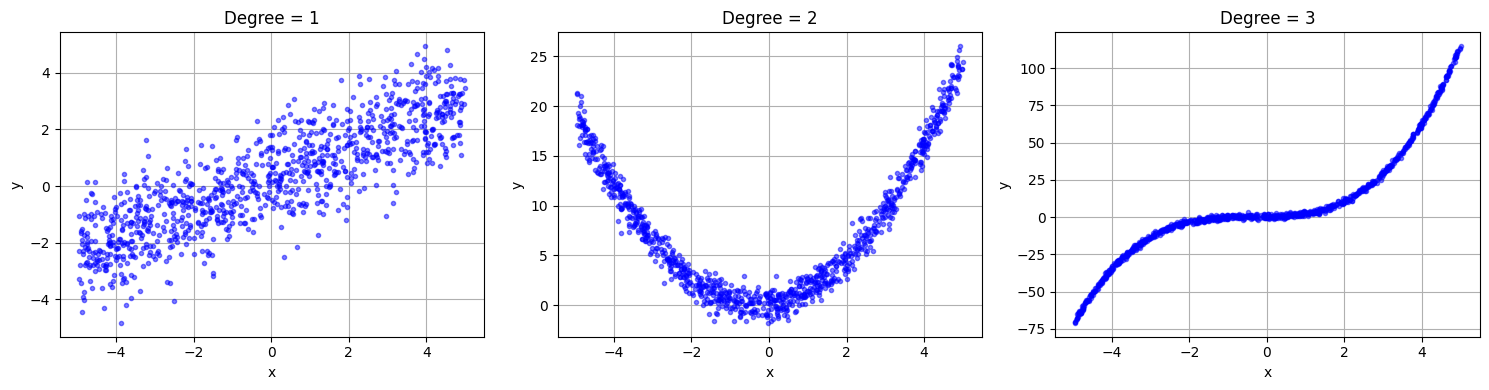

In [5]:
plot_datasets(degrees=[1, 2, 3], n_samples=1000)

## 3. Ridge Regression Methods

This section introduces two approaches for fitting a ridge regression model: a closed-form solution and an optimisation-based approach using stochastic gradient descent (SGD). Both methods minimise the same objective function but differ substantially in computational properties and scalability.

### 3.1 Closed-form Ridge Regression

Ridge regression is a regularized extension of linear regression, where an L2 penalty is added to the mean squared error (MSE) objective:

$$J(\theta) = \text{MSE}(\theta) + \alpha \sum_{i=1}^n \theta_i^2$$

The closed-form solution is given by the regularized normal equation:

$$\hat{w} = (X^TX + \alpha I_m)^{-1}X^Ty$$

Where:
- $X$ is the feature matrix (with bias term)
- $I_m$ is the identity matrix
- $\alpha$ is the regularization strength

To avoid penalizing the bias term, the first diagonal entry of the identity matrix is set to zero $I_{0,0} = 0$. This ensures that regularization is applied only to feature weights and not to the intercept.

**Strengths**

The closed-form solution directly computes the optimal parameters, providing an exact and numerically stable solution when the matrix is invertible. The regularisation term further improves stability and mitigates issues caused by multicollinearity or high-degree polynomial features.

**Computational Complexity**
- **Training time:** dominated by matrix inversion, which is cubic in the number of features $n$. Constructing the normal equation is linear in the number of samples $m$.
- **Prediction time:** linear with respect to both the number of samples and features.



**Implementation**

In [6]:
class RidgeRegression:
  def __init__(self, alpha=0.1):
    self.alpha = alpha
    self.weights = None

  def predict(self, X):
    num_samples, num_features = X.shape
    X_b = np.c_[(np.ones((num_samples, 1)), X)] # Add bias term
    z = X_b @ self.weights
    return z

  def fit(self, X, y):
    num_samples, num_features = X.shape
    X_b = np.c_[(np.ones((num_samples, 1)), X)]

    # Identity matrix
    I = np.identity(num_features + 1)
    I[0, 0] = 0 # avoid regularising bias term

    # Closed-form solution
    self.weights = np.linalg.inv(X_b.T @ X_b + self.alpha * I) @ X_b.T @ y


### 3.2 Ridge Regression with Stochastic Gradient Descent

Due to the computational complexity of the closed-form ridge regression solution, an alternative approach is to use an iterative optimisation algorithm such as Gradient Descent, which updates model parameters incrementally to minimise the loss function. This approach is particularly suitable when the number of features is large or when the dataset is too large to fit comfortably in memory.

Stochastic Gradient Descent (SGD) is a variant of gradient descent that updates parameters using only a single randomly selected training instance at each step. As a result, it is computationally efficient and scalable to large datasets.

**Why SGD is useful**
- Efficient on large data: avoids expensive matrix inversion  
- Scales to high-dimensional data: No matrix inversion — works even when the number of features is large  
- Flexible optimisation: supports early stopping and adaptive learning rates

However, due to its stochastic nature, SGD does not converge smoothly to the optimum and may oscillate around it. A common mitigation strategy is to gradually reduce the learning rate.

**Closed-form vs. SGD**

| Aspect              | Closed-form Ridge       | SGD Ridge                |
| ------------------- | ----------------------- | ------------------------ |
| Solution            | Exact                   | Approximate              |
| High dimensionality | Slow (matrix inversion) | Efficient                |
| Large sample size   | Fast                    | Fast                     |
| Stability           | High                    | Depends on learning rate |






### 3.3 Feature Scaling and Initial Comparison

**Feature Scaling**

- SGD updates weights based on gradients. If features have different scales, convergence can be slow or unstable.
- Ridge regression penalises large weights. Without scaling, features with larger magnitudes can dominate the optimisation.

Therefore, I apply feature standardisation after polynomial expansion for both methods.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


def preprocessing(degree):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler()
    )

**Bias–Variance Trade-off**

The experimental setup is as follows:
- Three datasets with known true polynomial degrees (1, 2, 3), each containing 1000 samples
- Three regularisation strengths: α = 0 (no regularisation), 0.1 (moderate), and 100 (strong)
    
Since the true underlying degree is known, the effect of model complexity can be interpreted as:
- **Model degree < true degree:** high bias, underfitting
- **Model degree = true degree:** appropriate complexity, lowest expected MSE
- **Model degree > true degree:** high variance, overfitting (regularisation may help)
    
In this section, I focus on the matched cases where the model degree equals the true degree. Section 4 explores mismatched model complexities.

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

results = {}
alphas = [0, 0.1, 100]

for degree, (X, y) in [(1, dataset1), (2, dataset2), (3, dataset3)]:
    for alpha in alphas:
        key = (degree, alpha)

        pipe = preprocessing(degree)
        X_scaled = pipe.fit_transform(X)

        # Closed-form Ridge
        ridge = RidgeRegression(alpha=alpha)
        ridge.fit(X_scaled, y)
        y_pred_ridge = ridge.predict(X_scaled)

        # SGDRegressor
        sgd = SGDRegressor(
            penalty='l2', alpha=alpha / len(X), learning_rate='adaptive',
            eta0=0.01, max_iter=1000, tol=None, random_state=42
        )
        sgd.fit(X_scaled, y.ravel())
        y_pred_sgd = sgd.predict(X_scaled)

        results[key] = {
            "X": X,
            "y": y,
            "y_ridge": y_pred_ridge,
            "y_sgd": y_pred_sgd,
            "ridge": ridge,
            "sgd": sgd,
            "ridge_mse": mean_squared_error(y, y_pred_ridge),
            "sgd_mse": mean_squared_error(y, y_pred_sgd)
        }

In [9]:
for (degree, alpha), res in results.items():
    print(
        f"Degree={degree:<2} | α={alpha:<5} | "
        f"Closed-form MSE: {res['ridge_mse']:<8.4f} | "
        f"SGD MSE: {res['sgd_mse']:<8.4f}"
    )

Degree=1  | α=0     | Closed-form MSE: 0.9771   | SGD MSE: 0.9803  
Degree=1  | α=0.1   | Closed-form MSE: 0.9771   | SGD MSE: 0.9803  
Degree=1  | α=100   | Closed-form MSE: 0.9975   | SGD MSE: 0.9987  
Degree=2  | α=0     | Closed-form MSE: 0.9307   | SGD MSE: 0.9332  
Degree=2  | α=0.1   | Closed-form MSE: 0.9307   | SGD MSE: 0.9332  
Degree=2  | α=100   | Closed-form MSE: 1.3088   | SGD MSE: 1.2329  
Degree=3  | α=0     | Closed-form MSE: 0.9767   | SGD MSE: 1.0121  
Degree=3  | α=0.1   | Closed-form MSE: 0.9767   | SGD MSE: 1.0121  
Degree=3  | α=100   | Closed-form MSE: 18.1269  | SGD MSE: 14.9735 


**Key Observations**
- When the model degree matches the true degree, both methods achieve low MSE.
- For degrees 1 and 2, closed-form ridge regression and SGD produce very similar results.
- Strong regularisation (α = 100) degrades performance, particularly for degree 3, indicating underfitting.  
- Even with correct model complexity, excessive regularisation can overly constrain both models.  
- SGD performs slightly better than the closed-form solution at high α values, but neither method performs well under extreme regularisation.

## 4. Experiments and Evaluation

### 4.1 Model Evaluation and Comparison



#### SGD Hyperparameter Setup
To achieve results comparable to the closed-form ridge regression, I configure the SGD model with the following hyperparameters:
- *penalty='l2'*: applies L2 regularisation  
- *alpha=alpha/len(X)*: scales the regularisation strength to match the closed-form objective  
- *fit_intercept=True*: learns the bias term directly
- *learning_rate='adaptive', eta0=0.01*:  uses an adaptive learning rate starting from `eta0`  
- *max_iter=1000*: sufficient for convergence given the dataset size
- *tol=None*: allows the model to run for all iterations  
- *random_state=42*: ensures reproducibility  

This configuration allows SGD to closely approximate the closed-form solution while remaining efficient.

#### Prediction Plots and Weight Comparison


To visually compare predictions from the two methods, I plot the fitted curves for different values of α.

In [10]:
def plot_comparison(results, degree):
    alphas = sorted(set(a for (d, a) in results if d == degree))
    fig, axes = plt.subplots(1, len(alphas), figsize=(15, 4))
    fig.suptitle(f"Degree {degree} – Prediction Comparison")

    for i, alpha in enumerate(alphas):
        ax = axes[i]
        res = results[(degree, alpha)]
        idx = res["X"].ravel().argsort()

        ax.plot(res["X"], res["y"], "b.", alpha=0.2)
        ax.plot(res["X"][idx], res["y_ridge"][idx], "r-", label="Closed-form", linewidth=2)
        ax.plot(res["X"][idx], res["y_sgd"][idx], "g--", label="SGD", linewidth=2)

        ax.set_title(f"α = {alpha}")
        ax.set_xlabel("x")
        if i == 0:
            ax.set_ylabel("y")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

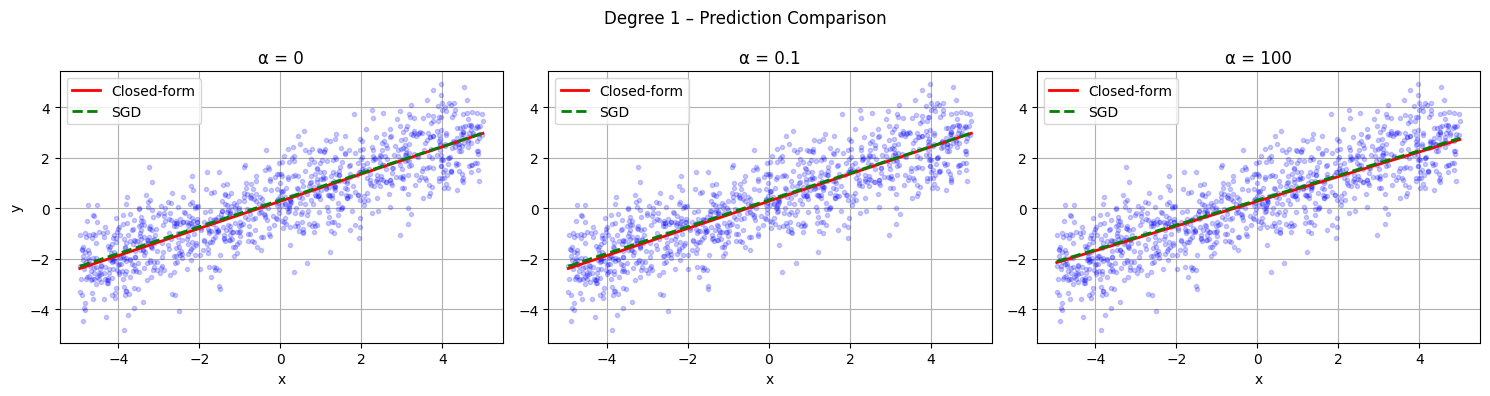

In [11]:
plot_comparison(results, 1)

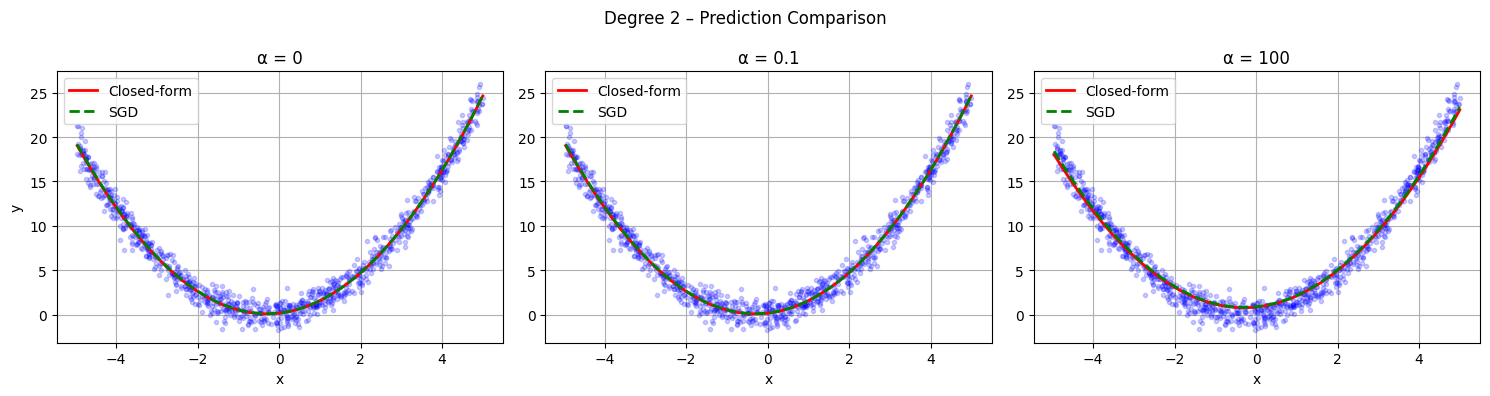

In [12]:
plot_comparison(results, 2)

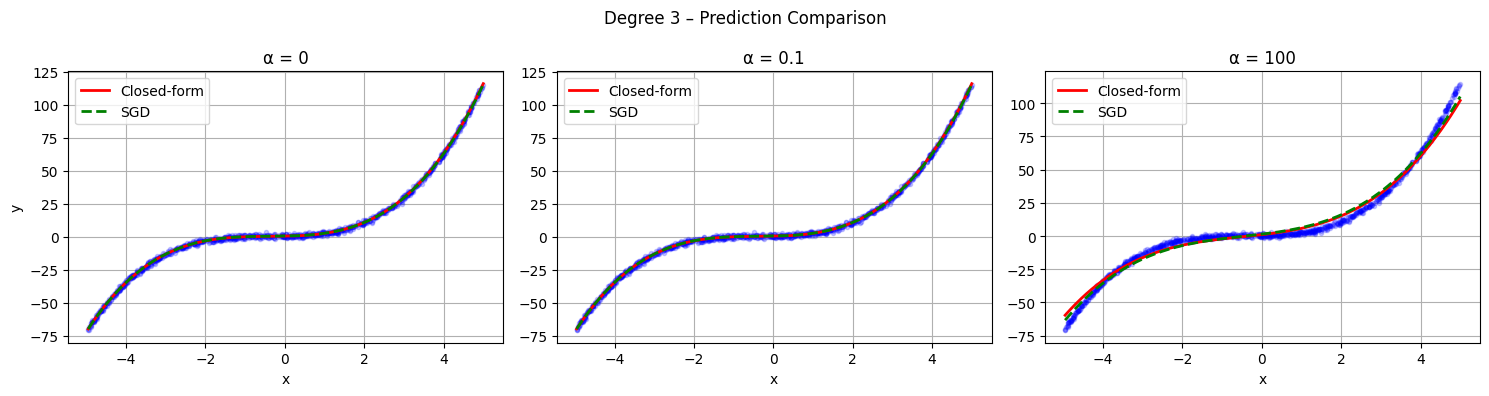

In [13]:
plot_comparison(results, 3)

**Key Observations (model degree = true degree)**
- For low-degree datasets (degree = 1 and 2), both methods produce nearly identical predictions across all α values.
- For degree = 3, predictions remain close; however, at α = 100 the curves become flatter, particularly for the closed-form model.
- Overall, visual differences between closed-form ridge and SGD are minimal at this scale.

Next, the learned coefficients from both models are compared.


In [14]:
for (degree, alpha), res in results.items():
    w_ridge = res["ridge"].weights.flatten()
    w_sgd = np.concatenate(([res["sgd"].intercept_[0]], res["sgd"].coef_))

    ridge_mse = res["ridge_mse"]
    sgd_mse = res["sgd_mse"]

    print(f"\nDegree={degree} | α={alpha}")
    print(f"  Closed-form: weights {np.round(w_ridge, 3)} MSE {ridge_mse:.4f}")
    print(f"  SGD        : weights {np.round(w_sgd, 3)} MSE {sgd_mse:.4f}")


Degree=1 | α=0
  Closed-form: weights [0.231 1.571] MSE 0.9771
  SGD        : weights [0.282 1.547] MSE 0.9803

Degree=1 | α=0.1
  Closed-form: weights [0.231 1.571] MSE 0.9771
  SGD        : weights [0.282 1.547] MSE 0.9803

Degree=1 | α=100
  Closed-form: weights [0.231 1.428] MSE 0.9975
  SGD        : weights [0.278 1.432] MSE 0.9987

Degree=2 | α=0
  Closed-form: weights [7.588 1.532 6.546] MSE 0.9307
  SGD        : weights [7.626 1.506 6.564] MSE 0.9332

Degree=2 | α=0.1
  Closed-form: weights [7.588 1.532 6.545] MSE 0.9307
  SGD        : weights [7.626 1.506 6.563] MSE 0.9332

Degree=2 | α=100
  Closed-form: weights [7.588 1.376 5.946] MSE 1.3088
  SGD        : weights [7.742 1.357 6.042] MSE 1.2329

Degree=3 | α=0
  Closed-form: weights [ 6.562  1.669  6.496 34.89 ] MSE 0.9767
  SGD        : weights [ 6.53   1.611  6.376 34.799] MSE 1.0121

Degree=3 | α=0.1
  Closed-form: weights [ 6.562  1.69   6.495 34.867] MSE 0.9767
  SGD        : weights [ 6.53   1.633  6.375 34.779] MSE 1

**Key Observations (weights)**
- In all cases, SGD learns weights very similar to those obtained from the closed-form solution.
- In the closed-form implementation, the bias term is excluded from regularisation, so its value remains constant across α values.
- Under strong regulazation (α = 100), both models shrink weights, particularly higher-degree terms ($x^2, x^3$)

#### Effect of Regularisation Strength (α)

Overall, both methods perform as expected:

- **Consistency**: When model degree matches the true degree, both methods produce similar MSE and learned weights.
- **Effect of α**: Larger α leads to stronger weight shrinkage. Even when model complexity is correct, excessive regularisation (e.g., degree = 3, α = 100) can cause underfitting.
- **Difference in treatment of bias**:  Closed-form excludes the bias term from regularisation, while SGD regularises all weights.
- Stability: Closed-form is highly stable; SGD performs well but may show slight fluctuations due to its stochastic updates.

Overall, both implementations perform similarly on low degree and small datasets, and the impacts of α influences match expections.

#### Effect of Model Complexity (Degree ≠ True Degree)

In practice, the true underlying function is unknown. To examine the bias–variance trade-off, I test different model degrees on a dataset with true degree = 3.

In [15]:
X, y = dataset3  # true degree = 3
model_degrees = [1, 3, 10]
alphas = [0, 0.1, 100]

for deg in model_degrees:
    for alpha in alphas:
        X_scaled = preprocessing(deg).fit_transform(X)

        # Closed-form Ridge
        ridge = RidgeRegression(alpha=alpha)
        ridge.fit(X_scaled, y)
        y_pred_ridge = ridge.predict(X_scaled)
        ridge_mse = mean_squared_error(y, y_pred_ridge)

        # SGD
        sgd = SGDRegressor(
            penalty='l2', alpha=alpha / len(X), learning_rate='adaptive',
            eta0=0.01, max_iter=1000, tol=None, random_state=42
        )
        sgd.fit(X_scaled, y.ravel())
        y_pred_sgd = sgd.predict(X_scaled)
        sgd_mse = mean_squared_error(y, y_pred_sgd)

        print(
            f"Model Degree = {deg:<2} | α = {alpha:<5} | "
            f"Closed-form MSE: {ridge_mse:<8.4f} | SGD MSE: {sgd_mse:<8.4f}"
        )

Model Degree = 1  | α = 0     | Closed-form MSE: 223.0226 | SGD MSE: 231.0801
Model Degree = 1  | α = 0.1   | Closed-form MSE: 223.0226 | SGD MSE: 231.0648
Model Degree = 1  | α = 100   | Closed-form MSE: 232.3707 | SGD MSE: 223.9788
Model Degree = 3  | α = 0     | Closed-form MSE: 0.9767   | SGD MSE: 1.0121  
Model Degree = 3  | α = 0.1   | Closed-form MSE: 0.9767   | SGD MSE: 1.0121  
Model Degree = 3  | α = 100   | Closed-form MSE: 18.1269  | SGD MSE: 14.9735 
Model Degree = 10 | α = 0     | Closed-form MSE: 0.9690   | SGD MSE: 1.1989  
Model Degree = 10 | α = 0.1   | Closed-form MSE: 0.9815   | SGD MSE: 1.1929  
Model Degree = 10 | α = 100   | Closed-form MSE: 10.4455  | SGD MSE: 13.6180 


**Observations**
- When model degree < true degree, both methods underfit (high bias, large MSE).
- When model degree = true degree, both methods achieve the lowest MSE; however, excessive regularisation can still cause underfitting.
- When model degree > true degree, overfitting increases. The closed-form solution remains relatively stable, while SGD becomes more sensitive at high complexity.
- Proper regularisation can still allow higher-degree models to perform well by constraining weights.

### 4.2 Scaling with Dataset Size and Model Complexity

In this section, I further evaluate ridge regression using **matched cases**
(model degree = ground truth), focusing on two dimensions:
- Scaling dataset size
- Increasing model complexity (polynomial degree)

The goal is to examine how closed-form ridge regression and SGD scale in practice, and whether their empirical behaviour aligns with theoretical expectations.



#### 4.2.1 Expectations
**Closed-form Ridge Regression**
- Accurate and numerically stable
- Fitting time increases with dataset size and polynomial degree
- According to *Hands-On Machine Learning* (Géron, 2019), computational complexity
  scales between $O(n^{2.4})$ and $O(n^3)$ with respect to feature dimension
- Prediction is relatively fast once the model is fitted

**Stochastic Gradient Descent (SGD)**
- Scales better with large datasets
- More sensitive to learning rate and regularisation strength (α), especially for complex models
- Different SGD strategies may behave differently:
  - *Early stopping*: faster but potentially less accurate
  - *Adaptive learning rate*: slower but closer to closed-form performance

**Expected Performance Trends**
- Closed-form fitting time grows faster with dataset size and polynomial degree
- Prediction time is approximately linear for both methods (in sample size or number of features)

For the experiments below:
- **α = 0.1** is used for dataset scaling experiments
- **α = 1 and 100** are used for model complexity experiments

In [16]:
import time

def evaluate_models(X, y, degree, alpha=0.1):
    # Polynomial expansion + scaling
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_poly)

    results = {}

    # Closed-form Ridge
    ridge = RidgeRegression(alpha=alpha)
    t0 = time.time()
    ridge.fit(X_poly, y)
    t1 = time.time()
    y_ridge = ridge.predict(X_poly)
    t2 = time.time()
    results["Ridge"] = {
        "mse": mean_squared_error(y, y_ridge),
        "fit_time": t1 - t0,
        "pred_time": t2 - t1
    }

    # SGD (early stopping)
    sgd_es = SGDRegressor(
        alpha=alpha / len(X), learning_rate='constant', eta0=0.01,
        early_stopping=True, validation_fraction=0.1,
        n_iter_no_change=10, max_iter=10000, tol=1e-4, random_state=42
    )
    t0 = time.time()
    sgd_es.fit(X_scaled, y.ravel())
    t1 = time.time()
    y_sgd_es = sgd_es.predict(X_scaled)
    t2 = time.time()
    results["SGD (early stop)"] = {
        "mse": mean_squared_error(y, y_sgd_es),
        "fit_time": t1 - t0,
        "pred_time": t2 - t1
    }

    # SGD (adaptive)
    sgd_adaptive = SGDRegressor(
        alpha=alpha / len(X), learning_rate='adaptive', eta0=0.01,
        early_stopping=False, max_iter=30000, tol=1e-3, random_state=42
    )
    t0 = time.time()
    sgd_adaptive.fit(X_scaled, y.ravel())
    t1 = time.time()
    y_sgd_adapt = sgd_adaptive.predict(X_scaled)
    t2 = time.time()
    results["SGD (adaptive)"] = {
        "mse": mean_squared_error(y, y_sgd_adapt),
        "fit_time": t1 - t0,
        "pred_time": t2 - t1
    }
    return results

#### 4.2.2 Effect of Dataset Size

Here, the polynomial degree is fixed at 5, while the number of training samples
is increased from 5,000 to 2,000,000.


In [17]:
sample_sizes = [5000, 10000, 20000, 50000, 100000, 1000000, 2000000]
scaling_results = {}

for n in sample_sizes:
    X_big, y_big = generate_dataset(degree=5, n_samples=n)
    scaling_results[n] = evaluate_models(X_big, y_big, degree=5)

In [18]:
for n, res in scaling_results.items():
    print(f"\nSamples = {n}")
    print(f"{'Model':<18} {'MSE':>10} {'Fit Time (s)':>15} {'Predict Time (s)':>18}")

    for model in ["Ridge", "SGD (early stop)", "SGD (adaptive)"]:
        r = res[model]
        print(f"{model:<18} {r['mse']:>10.4f} {r['fit_time']:>15.4f} {r['pred_time']:>18.4f}")


Samples = 5000
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge                  1.0374          0.0007             0.0002
SGD (early stop)       1.1128          0.0196             0.0003
SGD (adaptive)         1.0377          0.0270             0.0005

Samples = 10000
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge                  0.9989          0.0012             0.0003
SGD (early stop)       1.0341          0.0273             0.0004
SGD (adaptive)         1.0026          0.0513             0.0005

Samples = 20000
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge                  1.0033          0.0055             0.0006
SGD (early stop)       1.0068          0.0914             0.0006
SGD (adaptive)         1.0040          0.1161             0.0025

Samples = 50000
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge                  1.0035          0.0130             0.0043
SGD (early stop)       

**Comparison to Expectations**
- SGD is not always faster than closed-form; more iterations are needed to reach high accuracy
- Early stopping is faster but less accurate; adaptive SGD is slower but closer to closed-form results
- Timing trends largely match theory: SGD scales roughly linearly, while closed-form remains efficient even at large sample sizes
- Prediction time increases linearly for both methods

Overall, the results largely match expectations, with closed-form ridge performing surprisingly well even for very large datasets.

#### 4.2.3 Effect of Model Complexity

Here, the number of samples is fixed at 10,000, while the polynomial degree increases
from 5 to 20. Regularisation strengths α = 1 and 100 are evaluated.

In [19]:
alphas=[1, 100]

cases = [
    {"degree": 5, "n_samples": 10000},
    {"degree": 10, "n_samples": 10000},
    {"degree": 20, "n_samples": 10000},
]

complexity_alpha_results = {}

for case in cases:
    d, n = case["degree"], case["n_samples"]
    X, y = generate_dataset(degree=d, n_samples=n)
    for alpha in alphas:
        key = (d, n, alpha)
        complexity_alpha_results[key] = evaluate_models(X, y, degree=d, alpha=alpha)

In [20]:
for (d, n, alpha), res in complexity_alpha_results.items():
    print(f"\nDegree = {d}, Samples = {n}, α = {alpha}")
    print(f"{'Model':<18} {'MSE':>10} {'Fit Time (s)':>15} {'Predict Time (s)':>18}")
    for model in ["Ridge", "SGD (early stop)", "SGD (adaptive)"]:
        r = res[model]
        print(f"{model:<18} {r['mse']:>10.4e} {r['fit_time']:>15.4f} {r['pred_time']:>18.4f}")


Degree = 5, Samples = 10000, α = 1
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge              9.9887e-01          0.0011             0.0004
SGD (early stop)   1.5102e+00          0.0254             0.0003
SGD (adaptive)     1.3539e+00          0.0445             0.0005

Degree = 5, Samples = 10000, α = 100
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge              9.9888e-01          0.0009             0.0002
SGD (early stop)   6.0959e+02          0.0157             0.0005
SGD (adaptive)     5.2205e+02          0.0290             0.0004

Degree = 10, Samples = 10000, α = 1
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge              1.0087e+00          0.0021             0.0004
SGD (early stop)   8.6094e+07          0.0275             0.0004
SGD (adaptive)     1.2368e+07          0.1746             0.0005

Degree = 10, Samples = 10000, α = 100
Model                     MSE    Fit Time (s)   Predict Time (s)
Ridge

**Observations**
- At moderate degree (5), closed-form ridge is stable and accurate; SGD works but is more sensitive under strong regularisation
- At high degree (20), all methods struggle to converge; model complexity dominates even with strong regularisation
- Regularisation alone is insufficient to control extremely high-degree models
- Fitting time increases faster for closed-form due to matrix operations, while prediction remains fast

## 5. Conclusion
This project investigates ridge regression using both a closed-form solution and stochastic gradient descent (SGD) under controlled synthetic settings.

The experiments show that model complexity plays a critical role: under-parameterised models suffer from high bias, while overly complex models overfit unless properly regularised. Regularisation is effective, but excessive regularisation can still lead to underfitting even when model complexity is correct.

When model degree matches the data-generating process, closed-form ridge regression and SGD achieve very similar performance on small to medium-sized datasets. As dataset size increases, both methods scale well in practice, with early-stopping SGD trading accuracy for speed and adaptive SGD producing results closer to the closed-form solution.

Overall, the results highlight the practical trade-offs between exact and iterative optimisation methods, and illustrate how regularisation, optimisation strategy, and model complexity interact
in ridge regression.

## 6. Reference
- Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd ed.). O’Reilly Media.